# A small neural network that predicts whether float is > 0. Only using numpy & pyplot. Which is actually quite a lot. 

# Totally overcommented. Because I had fun!

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# Let's define useful stuff & check it.

In [ ]:
#all red ''' comments ''' are just me thinking in text;
#green-blue #commets ike this one might be useful;
#and might be not;

In [3]:
#uniformly random normalised matrix for weights, biases & tests;
def unm(m, n):
    matrix = np.random.uniform(-1, 1, size=(m,n))
    return matrix / np.sqrt(m*n)

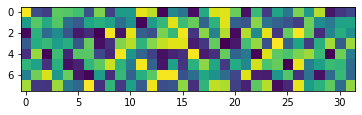

In [133]:
plt.imshow(unm(8, 32))
plt.show()

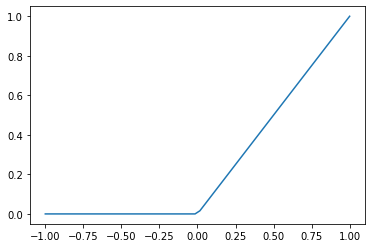

In [4]:
relu = lambda x: np.maximum(x, 0.)

x = np.linspace(-1, 1, 64)
plt.plot(x, relu(x))
plt.show()

In [5]:
def softmax(x):
    exps = np.exp(x - np.max(x))
    return exps / np.sum(exps)

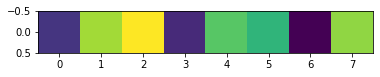

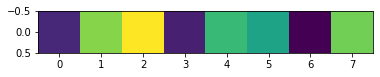

sum(softmax(x)) =  1.0
nice!


In [134]:
x = unm(8, 1)
plt.imshow(x.T)
plt.show()

plt.imshow(softmax(x.T))
plt.show()

#it's good if sum is ~1.0;
print("sum(softmax(x)) = ", float(sum(softmax(x))))
print("nice!")

In [85]:
def matrix_softmax(m):
    return np.apply_along_axis(softmax, 0, m)

t = unm(2,3)
print(t)
matrix_softmax(t)

[[-0.1583079   0.15597987 -0.04853325]
 [-0.31919008  0.19380998 -0.18389419]]


array([[0.54013402, 0.4905436 , 0.53378866],
       [0.45986598, 0.5094564 , 0.46621134]])

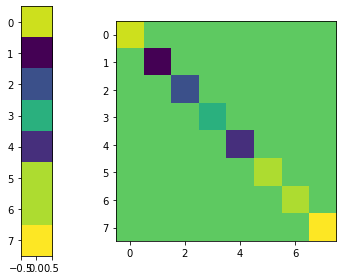

In [7]:
#returns diagonal matrix with entries from column vector v;
def dm(v):
    l = len(v)
    m = np.zeros([l, l])
    np.fill_diagonal(m, v)
    return m

v = unm(8,1)
plt.subplot(1,2,1)
plt.imshow(v)
plt.subplot(1,2,2)
plt.imshow(dm(v))
plt.tight_layout()

# Stuff's ready - let's do a draft.

In [93]:
'''
individual forward path takes float -1 < x < 1
and tries to predict probability distribution of it being > 0;
    0.5  -> [1, 0]
    -0.7 -> [0, 1]
       x -> [1 if (x > 0) else 0, 1 if (x < 0) else 0]
       
a good model would do something like:
    0.1 -> [0.7, 0.3]
   -0.2 -> [0.2, 0.8]
   loss is cross entropy between [0, 1] and [0.2, 0.8];
'''

#one forward pass

#random weight & biases
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)


#layers are x before activation and l after

#input = x0
x0 = np.array([[0.5],[1],[8]]).T

#hidden layer
x1 = x0 * W0 + b0
l1 = relu(x1)

#l2 is output
x2 = W1 @ l1 + b1
l2 = matrix_softmax(x2)

dloss_dx2 = (l2 - np.zeros(l2.shape)).T
#jacobians for computing 4 useful gradients;
dx2_dl1 = W1
dl1_dx1 = dm(l1>0)
dx1_dW0 = W0
dx2_dW1 = (l1.T)

#chain rule for jacobians produces gradients;
#these 4 will be used in SGD;
#but like any enterprise, when under a new management, 
#there's always a slight duplication of efforts.

dloss_dW0 = l1 * dx1_dW0 * (dx2_dl1.T @ dloss_dx2.T)

dloss_dW1 = dloss_dx2.T @ dx2_dW1
dloss_db0 = (dloss_dx2 @ dx2_dl1 @ dl1_dx1).T
dloss_db1 = dloss_dx2.T
#seems to work!

print("W1", W1.shape)
print("dloss_dW1", dloss_dW1.shape)

print("W0", W0.shape)
print("dloss_dW0", dloss_dW0.shape)

print("b0", b0.shape)
print("dloss_db0", dloss_db0.shape)

print("b1", b1.shape)
print("dloss_db1", dloss_db1.shape)

#shapes seem to be reasonable

W1 (2, 8)
dloss_dW1 (2, 8)
W0 (8, 1)
dloss_dW0 (8, 3)
b0 (8, 1)
dloss_db0 (8, 3)
b1 (2, 1)
dloss_db1 (2, 3)


# Let's write a function that returns gradients.

In [124]:
def grads(train, labels, W0, W1, b0, b1):
    
    '''
    -> dloss_dW0, dloss_dW1, dloss_db0, dloss_db1
    
    The vagones of the row vector train (np.array) are floats.
    Each one of them is a training example. 
    And has a corresponding lable in labels.
    In my particular case each lables[i] is [1, 0] if train[i] > 0,
    and [0, 1] otherwise.
    The length of train is the batch size.
    W & b are weights & biases.
    Returns gradients of W & b.
    '''
    
    
    x0 = train

    x1 = x0 * W0 + b0
    l1 = relu(x1)

    x2 = W1 @ l1 + b1
    l2 = softmax(x2)

    dloss_dx2 = (l2 - labels).T
    
    dx2_dl1 = W1
    dl1_dx1 = dm(l1>0)
    dx1_dW0 = W0
    dx2_dW1 = (l1.T)
    
    
    dloss_dW0 = ((dx2_dl1.T @ dloss_dx2.T) @ l1.T) @  dx1_dW0

    dloss_dW1 = dloss_dx2.T @ dx2_dW1
    dloss_db0 = ((dloss_dx2 @ dx2_dl1 @ dl1_dx1).T).sum(axis=1).reshape(-1,1)

    dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)

    return (dloss_dW0, dloss_dW1, dloss_db0, dloss_db1)

In [165]:
#generate smol data;
small_train = unm(1, 10)
small_lables = np.array([np.array([1, 0]) if el > 0 else np.array([0, 1]) for el in small_train[0]]).T

Train:


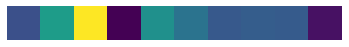

Lables:


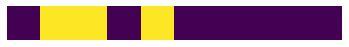

Very nice!
We get pure hot, where it used to be hotter than 0.
And super chill, where it used to be < 0.


In [173]:
#let's check how reasonable the lables are;
#we don't do these things because they are easy;
#we choose to go to the moon because it's hard;

plt.imshow(small_train)
plt.axis('off')
print("Train:")
plt.show()

plt.axis('off')
check_lables = np.array([(small_lables.T[i][0] == 1) + 0. for i in range(10)])
plt.imshow(check_lables.reshape(1, 10))
print("Lables:")
plt.show()

print("Very nice!\nWe get pure hot, where it used to be hotter than 0.\nAnd super chill, where it used to be < 0.")

In [178]:
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)

grads(small_train, small_lables, W0, W1, b0, b1)

(array([[-0.10015884],
        [-0.03804341],
        [ 0.18715007],
        [ 0.07601161],
        [ 0.07754393],
        [-0.09112869],
        [-0.1275932 ],
        [ 0.01194222]]),
 array([[ 0.        , -0.86478876,  0.01033836,  0.        , -0.13451883,
          0.        , -0.71837991, -0.39122632],
        [ 0.        , -2.18853442, -0.19556299,  0.        ,  0.00514019,
          0.        , -2.5425823 , -1.51334848]]),
 array([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]]),
 array([[-2.35239698],
        [-6.64760302]]))

In [198]:
#generating a lot of data
def data(bs):
    small_train = unm(1, bs)
    small_lables = np.array([np.array([1, 0]) if el > 0 else np.array([0, 1]) for el in small_train[0]]).T
    return (small_train, small_lables)

#let's do data for 5 epoches with 256 batch size
examples = [data(256) for _ in range(5)]

# We are ready for training???

In [209]:
lr = 0.01

#random initial parameters;
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)

for batch in examples:
    x, y = batch
    dloss_dW0, dloss_dW1, dloss_db0, dloss_db1 = grads(x, y, W0, W1, b0, b1)
    W0 = W0 - dloss_dW0 * lr
    W1 = W1 - dloss_dW1 * lr
    b0 = b0 - dloss_db0 * lr
    b1 = b1 - dloss_db1 * lr
    

In [241]:
x0 = -0.05

x1 = x0 * W0 + b0
l1 = relu(x1)

x2 = W1 @ l1 + b1
l2 = softmax(x2)
l2.round(3)

array([[0.],
       [1.]])

In [241]:
small_train = unm(1, 6)
small_lables = np.array([np.array([1, 0]) if el > 0 else np.array([0, 1]) for el in small_train[0]])

In [245]:
small_train.reshape(3, 2)

array([[-0.05850445, -0.3790871 ],
       [ 0.34338963,  0.3863616 ],
       [-0.20696696,  0.09398707]])

In [251]:
small_train

array([[-0.05850445, -0.3790871 ,  0.34338963,  0.3863616 , -0.20696696,
         0.09398707]])

In [222]:
[i for i in small_train.reshape(2, 2)][0]

array([-0.02800081, -0.18762683])

In [253]:
(small_lables.reshape(3, 2, 2))

array([[[0, 1],
        [0, 1]],

       [[1, 0],
        [1, 0]],

       [[0, 1],
        [1, 0]]])

In [239]:
small_lables[1]

array([0, 1])

In [238]:
small_train[0][1]

-0.18762682995270796

In [240]:
small_train.reshape(2, 2)[0][1]

-0.18762682995270796

In [256]:
train.reshape(bs, int(65536/bs))

array([[ 6.19003115e-04, -1.09004678e-03,  2.00899227e-04, ...,
        -9.21052977e-04,  3.57384628e-03, -3.49886038e-03],
       [-2.05687594e-03,  4.58381604e-05, -4.69034492e-04, ...,
         3.69259890e-03, -3.29902922e-03,  8.69313834e-04],
       [-5.17828927e-04, -8.34264207e-04,  2.23210995e-03, ...,
         3.85903609e-03,  2.99789637e-03,  2.19243210e-04],
       ...,
       [-1.18508026e-03,  1.09872857e-03,  6.19885768e-04, ...,
         2.64785330e-03, -8.52245879e-05,  3.38109297e-04],
       [ 2.05589069e-03,  3.25634906e-04,  2.40469533e-03, ...,
         3.75328825e-03, -2.39491476e-03, -3.22329638e-03],
       [-3.02616856e-03,  2.91599545e-03,  3.34308038e-03, ...,
        -1.91439468e-03,  2.96186157e-03, -2.27952789e-03]])

In [258]:
(lables.reshape(bs, int(65536/bs), 2))

array([[[1, 0],
        [0, 1],
        [1, 0],
        ...,
        [0, 1],
        [1, 0],
        [0, 1]],

       [[0, 1],
        [1, 0],
        [0, 1],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]],

       [[0, 1],
        [0, 1],
        [1, 0],
        ...,
        [1, 0],
        [1, 0],
        [1, 0]],

       ...,

       [[0, 1],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [1, 0]],

       [[1, 0],
        [1, 0],
        [1, 0],
        ...,
        [1, 0],
        [0, 1],
        [0, 1]],

       [[0, 1],
        [1, 0],
        [1, 0],
        ...,
        [0, 1],
        [1, 0],
        [0, 1]]])

In [281]:
batches = train.reshape(bs, int(65536/bs))
print(batches[0])

[ 6.19003115e-04 -1.09004678e-03  2.00899227e-04  8.77671968e-05
 -1.87738464e-03  2.77817081e-03  1.21401215e-03 -3.08835565e-03
 -2.92305705e-03  2.03533781e-03 -3.68714864e-03  6.41986857e-04
 -1.29147329e-03  1.88133191e-03  1.61133415e-03 -1.64204167e-03
 -4.80664810e-04  3.59626668e-03  1.73597982e-03  1.43141799e-03
 -3.62555252e-03  1.12873265e-03 -1.55108352e-03 -2.51468669e-03
 -3.22127638e-03 -3.19968975e-03  3.74699043e-04  5.30760154e-04
 -9.10452765e-04 -1.67492137e-03  3.67140921e-05  3.37210098e-03
  3.52574089e-03 -2.94864920e-03  3.21806654e-03  7.16463981e-05
  3.51842336e-03  1.42969602e-04  9.20527196e-04 -1.26268498e-03
 -3.36814330e-04 -2.75176441e-03 -3.64283667e-03 -1.48676047e-03
  2.50651812e-03  3.30130044e-03 -9.01948695e-04  2.16548040e-03
 -3.79823419e-03 -3.74666185e-03  2.55699074e-03  3.31958440e-03
 -3.90345247e-03 -1.01579151e-03  1.51095540e-03 -3.01374526e-03
 -1.27559130e-04  3.70758548e-03  2.77306729e-03  1.80541077e-03
  2.91674421e-03 -1.23760

In [275]:
lables_ = (lables.reshape(bs, int(65536/bs), 2))

In [284]:
batches = (train.reshape(bs, int(65536/bs)), lables.reshape(bs, int(65536/bs), 2))

In [352]:
x = np.array([[1, 1, 2],
             [2, 3, 5]])
x.sum(axis=0).reshape(1,-1).shape

(1, 3)

In [350]:
x.sum(axis=0)

array([3, 4, 7])

In [ ]:
[[0.05363689 0.03176142]
 [0.05362017 0.0320996 ]
 [0.04834728 0.0302068 ]
 [0.04308776 0.02919489]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]
 [0.04564182 0.02969653]]

In [368]:
x = np.array([1, 2, 3])
y = np.array([[1],
              [2],
              [3]])

In [371]:
x @ y

array([14])

In [372]:
np.outer(x, y)

array([[1, 2, 3],
       [2, 4, 6],
       [3, 6, 9]])

In [134]:
#one forward pass

#random weight & biases
W0 = unm(8, 1)
b0 = unm(8, 1)
W1 = unm(2, 8)
b1 = unm(2, 1)


#layers are x before activation and l after

#input = x0
x0 = np.array([[0.5],[5],[3]]).T
print(x0.shape)
#hidden layer
x1 = x0 * W0 + b0
l1 = relu(x1)

#l2 is output
x2 = W1 @ l1 + b1
l2 = softmax(x2)

dloss_dx2 = (l2 - np.zeros(l2.shape)).T
#jacobians for computing 4 useful gradients;
dx2_dl1 = W1
dl1_dx1 = dm(l1>0)
dx1_dW0 = W0
dx2_dW1 = (l1.T)

#chain rule for jacobians produces gradients;
#these 4 will be used in SGD;
#but like any enterprise, when under a new management, 
#there's always a slight duplication of efforts.

dloss_dW0 = ((dx2_dl1.T @ dloss_dx2.T) @ l1.T) @  dx1_dW0

dloss_dW1 = dloss_dx2.T @ dx2_dW1
dloss_db0 = ((dloss_dx2 @ dx2_dl1 @ dl1_dx1).T).sum(axis=1).reshape(-1,1)

dloss_db1 = (dloss_dx2.T).sum(axis=1).reshape(-1,1)

print(dloss_dx2.shape , dx2_dl1.shape)


#seems to work!

print("W1", W1.shape)
print("dloss_dW1", dloss_dW1.shape)

print("W0", W0.shape)
print("dloss_dW0", dloss_dW0.shape)

print("b0", b0.shape)
print("dloss_db0", dloss_db0.shape)

print("b1", b1.shape)
print("dloss_db1", dloss_db1.shape)

'''
W0 = W0 - dloss_dW0 * lr
W1 = W1 - dloss_dW1 * lr
b0 = b0 - dloss_db0 * lr
b1 = b1 - dloss_db1 * lr
'''

#shapes seem to be reasonable

(1, 3)
(3, 2) (2, 8)
W1 (2, 8)
dloss_dW1 (2, 8)
W0 (8, 1)
dloss_dW0 (8, 1)
b0 (8, 1)
dloss_db0 (8, 1)
b1 (2, 1)
dloss_db1 (2, 1)


'\nW0 = W0 - dloss_dW0 * lr\nW1 = W1 - dloss_dW1 * lr\nb0 = b0 - dloss_db0 * lr\nb1 = b1 - dloss_db1 * lr\n'

In [118]:
dloss_db1

array([[0.13499824, 0.12882983, 0.13052086],
       [0.17046746, 0.23383489, 0.20134871]])

In [121]:
dloss_db1.sum(axis=1).reshape(-1,1).shape

(2, 1)

In [105]:
(dx1_dW0.l1T).shape

(1, 8)

In [116]:
dloss_dx2.shape

(3, 2)